### This notebook is tested on CPU only

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import params
from imports import *
from DDQNSolver import DDQNSolver

# Plot rewards during training

In [53]:
save_directory = "Dueling_Double_DQN/v2"
checkpoint_period = params.log_period
files = glob.glob(save_directory + "/rewards*.txt")
restart_episodes=[] #Which episodes did we restart the run from?

In [54]:
a = np.zeros((1,3))
for i,file in enumerate(sorted(files)):
    print(file)
    tmp = np.loadtxt(file)
    if i<len(restart_episodes):
        trunc = int(restart_episodes[i]/checkpoint_period)
        tmp = tmp[:trunc,:] #Truncate reward files to points of restart
        print(restart_episodes[i],tmp.shape)
    tmp[:,0] += a.shape[0] #Add length of episodes from first run to column values
    a = np.append(a, tmp, axis=0)
a = a[1:] #Remove the first placeholder zeros
a.shape

Dueling_Double_DQN/v2/rewards2.txt


(1000, 3)

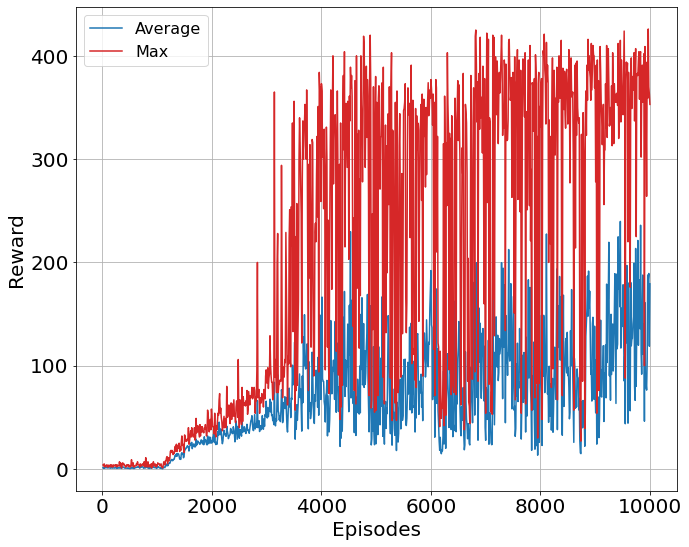

In [55]:

matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(a[:,0]*checkpoint_period,a[:,1], label="Average")
ax.set_ylabel("Reward")
ax.set_xlabel("Episodes")
#ax.set_ylim(0,a[:,2].max())
#ax2 = ax.twinx()
ax.plot(a[:,0]*checkpoint_period,a[:,2], 'C3-', label="Max")
#ax2.set_ylabel("Max Reward", color='tab:red')
plt.tight_layout()
plt.legend(fontsize=16)
ax.grid()

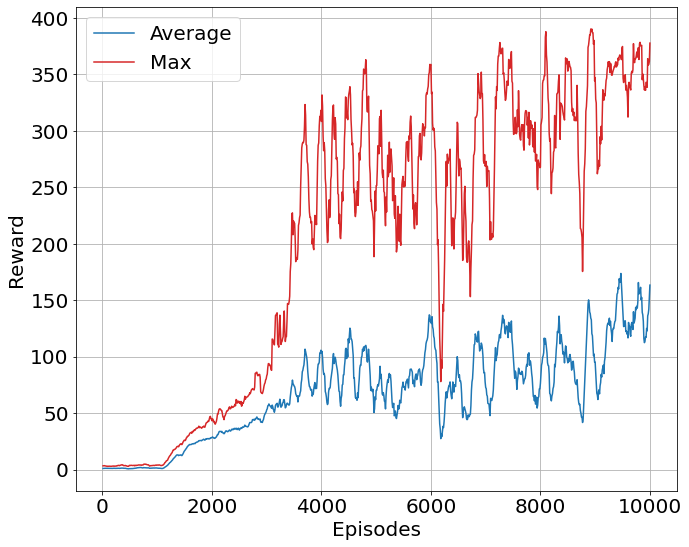

In [56]:
#Thing this is moving average with window of 10
from scipy.ndimage.filters import uniform_filter1d

checkpoint_period = 10

b = uniform_filter1d(a[:,1], size=10)
c = uniform_filter1d(a[:,2], size=10)

matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(a[:,0]*checkpoint_period,b, label="Average")
ax.set_ylabel("Reward")
ax.set_xlabel("Episodes")
#ax.set_ylim(0,a[:,2].max())
#ax2 = ax.twinx()
ax.plot(a[:,0]*checkpoint_period,c, 'C3-', label="Max")
#ax.set_ylabel("Max Reward", color='tab:red')
plt.tight_layout()
plt.legend()
ax.grid()

# Make a movie

In [57]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [58]:
#DQNAgent
import pickle
class DDQNAgent:
    def __init__(self, action_dim, obs_dim, save_directory, rewards_file):
        self.action_dim = action_dim
        self.save_directory = save_directory
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.net = DDQNSolver(self.action_dim, obs_dim).to(self.device)
        self.exploration_rate = 1.0
        self.exploration_rate_decay = params.exploration_rate_decay
        self.exploration_rate_min = params.exploration_rate_min
        self.current_step = 0
        self.memory = deque(maxlen=100000) #Not sure why, this version does not keep memory on GPU
        #But 20 GB gets filled with 100k frames
        self.batch_size = 32
        self.gamma = 0.95 #Reward decay
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-4)
        self.loss = torch.nn.SmoothL1Loss()
        self.episode_rewards = []
        self.moving_average_episode_rewards = []
        self.max_average_episode_rewards = []
        self.current_episode_reward = 0.0
        self.burn_in = self.batch_size*10
        self.learn_every = params.learn_every #Every how many collect steps to train
        self.sync_period = 2500*self.learn_every #COPY ONLINE NETWORK TO OFFLINE
        self.rewards_file = rewards_file

        
    def log_episode(self):
        self.episode_rewards.append(self.current_episode_reward)
        self.current_episode_reward = 0.0

    def log_period(self, episode, epsilon, step):
        self.moving_average_episode_rewards.append(np.round(np.mean(self.episode_rewards[-checkpoint_period:]), 3))
        self.max_average_episode_rewards.append(np.round(np.max(self.episode_rewards[-checkpoint_period:]), 3))
        print(f"Episode {episode} | Step {step} | Exploration rate {epsilon:.2f} \
        | Mean Reward {self.moving_average_episode_rewards[-1]} \
        | Max Reward {self.max_average_episode_rewards[-1]}")

        with open(os.path.join(self.save_directory,self.rewards_file), 'w') as f:
            for i, (reward1,reward2) in enumerate(zip(self.moving_average_episode_rewards,self.max_average_episode_rewards)):
                f.write("%d %.1f %.1f\n" %(i,reward1,reward2))


    def remember(self, state, next_state, action, reward, done):
        self.memory.append((torch.tensor(state.__array__()), torch.tensor(next_state.__array__()),
                            torch.tensor([action]), torch.tensor([reward]), torch.tensor([done])))

        
    def experience_replay(self, step_reward):
        self.current_episode_reward += step_reward
        
        if self.current_step%self.sync_period == 0: #Copy network pieces if time
            self.net.target_conv.load_state_dict(self.net.conv.state_dict())
            self.net.target_linear_adv.load_state_dict(self.net.linear_adv.state_dict())
            self.net.target_linear_val.load_state_dict(self.net.linear_val.state_dict())
            
        if len(self.memory)<self.burn_in: #Don't train till have collected enough data
            if(self.current_step%100==0): 
                print("Collecting data without training on step %d" %self.current_step)
            return

        if self.current_step%self.learn_every !=0 : #Learn every N steps
            return
        
        state, next_state, action, reward, done = self.recall()
        q_estimate = self.net(state.cuda(), model="online")[np.arange(0, self.batch_size), action.cuda()]
        with torch.no_grad():
            action_preds = self.net(next_state.cuda(), model="online")
            best_action = torch.argmax(action_preds, dim=1)
            
            next_q = self.net(next_state.cuda(), model="target")[np.arange(0, self.batch_size), best_action]
            q_target = (reward.cuda() + (1 - done.cuda().float()) * self.gamma * next_q).float()
        loss = self.loss(q_estimate, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        
    def recall(self):
        state, next_state, action, reward, done = map(torch.stack, zip(*random.sample(self.memory, self.batch_size)))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

    def act(self, state):
        if np.random.rand() < self.exploration_rate:
            action = np.random.randint(self.action_dim)
        else:
            action_values = self.net(torch.tensor(state.__array__()).unsqueeze(0), model="online")
            action = torch.argmax(action_values, dim=1).item()
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)
        self.current_step += 1
        return action

    
    def load_checkpoint(self, path):
        checkpoint = torch.load(path, map_location=torch.device('cpu'))
        self.net.load_state_dict(checkpoint['model'])
        self.exploration_rate = checkpoint['exploration_rate']

        
    def save_checkpoint(self):
        filename = os.path.join(self.save_directory, 'checkpoint_{}.pth'.format(episode))
        torch.save(dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate), f=filename)
        print('Checkpoint saved to \'{}\''.format(filename))
        
        #Save experience replay for checkpointing
        filename = os.path.join(self.save_directory, 'memory_{}.pkl'.format(episode))
        p_file = open(filename, 'wb')
        pickle.dump(self.memory, p_file)
        p_file.close()

In [59]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = Box(low=0, high=255, shape=self.observation_space.shape[:2], dtype=np.uint8)

    def observation(self, observation):
        transform = transforms.Grayscale()
        return transform(torch.tensor(np.transpose(observation, (2, 0, 1)).copy(), dtype=torch.float))


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        self.shape = (shape, shape)
        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transformations = transforms.Compose([transforms.Resize(self.shape), transforms.Normalize(0, 255)])
        return transformations(observation).squeeze(0)

In [60]:

env = gym.make('BreakoutNoFrameskip-v4')

# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

In [61]:
agent = DDQNAgent(action_dim=env.action_space.n, obs_dim = env.observation_space.shape,
                  save_directory=save_directory, rewards_file=params.rewards_file)

Flattened layer size is 6400
Flattened layer size is 6400


In [62]:
!pip install imageio-ffmpeg

In [64]:
load_checkpoint = "checkpoint_10000.pth"
agent.load_checkpoint(save_directory + "/" + load_checkpoint)
print ("Exploration rate: %.2f" %agent.exploration_rate)


import imageio
import base64
import IPython
num_episodes = 3
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=40) as video:
  for i in range(num_episodes):
    print ("Rendering episode %d" %(i+1))
    next_state = env.reset()
    while True:
        action = agent.act(next_state)
        next_state, reward, done, info = env.step(action)
        video.append_data(env.render(mode="rgb_array"))
        if done:
            break

embed_mp4(video_filename)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Exploration rate: 0.01
Rendering episode 1
Rendering episode 2
Rendering episode 3
